# IRENE

“For those who pass it without entering, the city is one thing; it is another for those who are trapped by it and never leave. There is the city where you arrive for the first time; and there is another city which you leave never to return. Each deserves a different name; perhaps I have already spoken of Irene under other names; perhaps I have spoken only of Irene.”

In [1]:
from __future__ import print_function
from IPython.display import Image

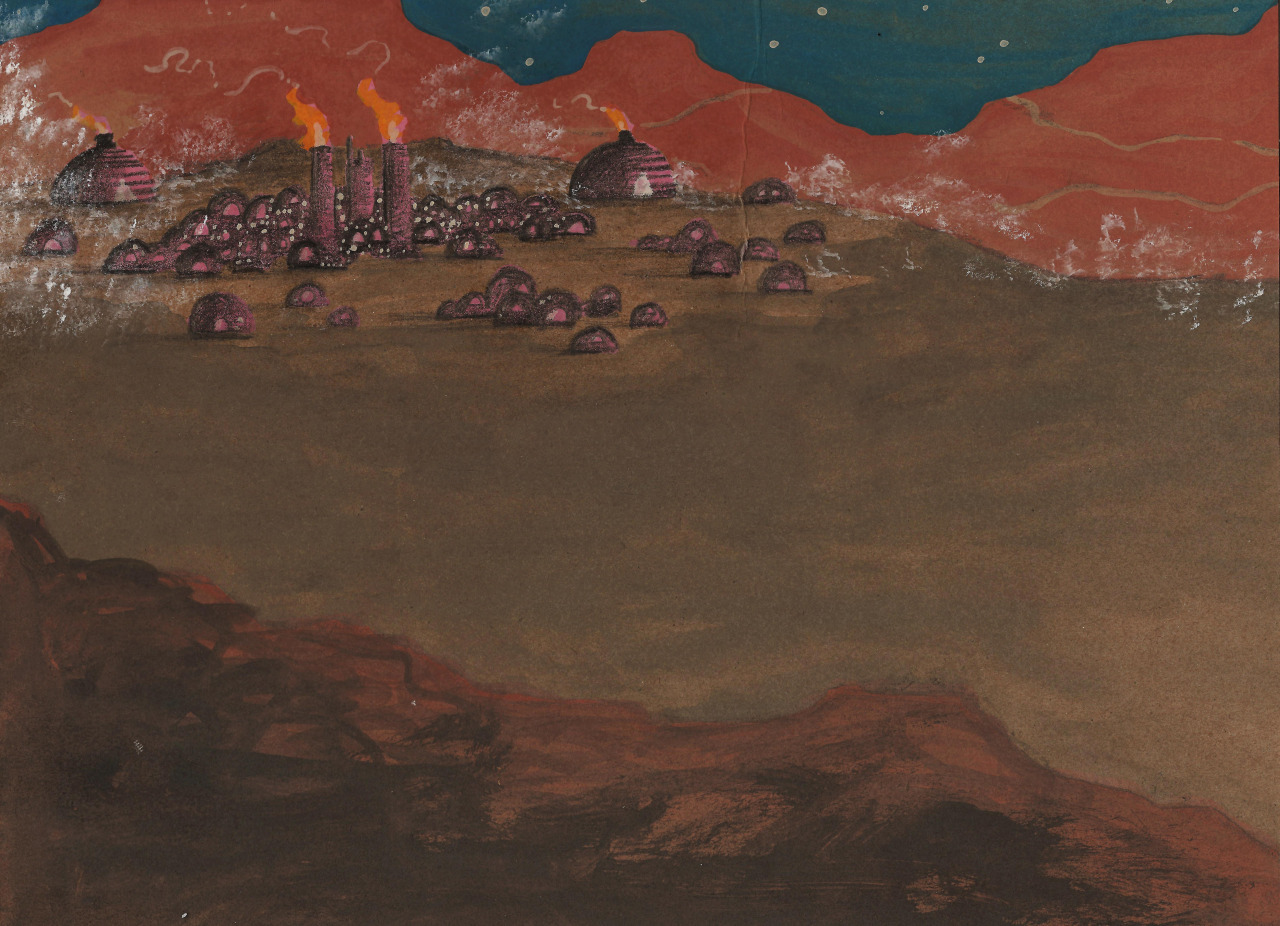

In [2]:
Image(filename='../../../Images/Irene.jpg') 

#### The city of IRENE performs a fast processing directly from raw data (pmtrwf and sipmrwf) to PMAPS. It is optimized for speed (use of CYTHON functions) and intended for fast processing of data at LSC

In [3]:
import time
%matplotlib inline
%load_ext autoreload
import matplotlib.pyplot as plt
import pandas as pd
import tables as tb
import numpy as np
import Core.mplFunctions as mpl
import Core.wfmFunctions as wfm
from Database import loadDB
import ICython.Sierpe.BLR as blr
import ICython.Core.peakFunctions as cpf
import Core.peakFunctions as pf
from ICython.Core.system_of_units import SystemOfUnits 
from scipy import signal
%load_ext Cython

In [4]:
print(time.strftime("%d/%m/%Y"))
print(time.strftime("%H:%M:%S"))

11/12/2016
00:39:46


In [5]:
from time import time

### Preproc Steps

1. Deconvolute RWF
2. Compute calibrated sum of PMTs (including MAU threshold)
3. Zero Suppression (ZS) in PMTs
4. S1 search (analysis specific)
5. S2 search (analysis specific) and rebin
6. ZS in SiPMs
7. Select S2 in ZS SiPMs 

For fast pre-proc, all the above steps must be computed on the fly (e.g, minimal access to disk) and
using pre-compiled (cython) functions in calculation-intensive parts (loops)

### Test data

In [6]:
path='/Users/jjgomezcadenas/Documents/Development/NEXT/icdata/LSC/run2976/'
ffile = 'run_2976.gdc1next.000.next1el_2976.root.h5'
r2976 = tb.open_file(path+ffile,'r+')
pmtrwf = r2976.root.RD.pmtrwf
sipmrwf = r2976.root.RD.sipmrwf
NEVT, NPMT, PMTWL = pmtrwf.shape
NEVT, NSIPM, SIPMWL = sipmrwf.shape
print("""
        Number of events in file = {}
        Number of PMTs = {}
        PMTWL = {}
        Number of SiPMs = {}
        SiPMWL = {}
      """.format(NEVT, NPMT, PMTWL,NSIPM, SIPMWL))


        Number of events in file = 91
        Number of PMTs = 12
        PMTWL = 48000
        Number of SiPMs = 1792
        SiPMWL = 1200
      


### Access to data base and definition of units

In [7]:
DataPMT = loadDB.DataPMT(2976)
units = SystemOfUnits()
adc_to_pes = abs(DataPMT.adc_to_pes.values)
coeff_c = abs(DataPMT.coeff_c.values)
coeff_blr = abs(DataPMT.coeff_blr.values)
DataSiPM = loadDB.DataSiPM(2976)
adc_to_pes_sipm = DataSiPM.adc_to_pes.values
xs = DataSiPM.X.values
ys = DataSiPM.Y.values

In [8]:
DataPMT

,SensorID,ChannelID,PmtID,Active,X,Y,coeff_c,coeff_blr,adc_to_pes,noise_rms,sigma
0,0,0,1,1,-23.9414,65.7785,0.000003,0.001632,-24.3395,0.7060,7.73100
1,1,18,3,1,-44.9951,-53.6231,0.000003,0.001632,-24.8580,0.8744,8.82000
2,2,1,2,1,68.9365,-12.1554,0.000003,0.001611,-26.2934,0.7213,8.01375
3,3,19,4,1,0.0000,185.0000,0.000003,0.001599,-26.4110,0.7624,8.42224
4,4,27,C,1,-118.9160,141.7180,0.000003,0.001567,-26.7098,0.7921,6.23125
5,5,26,B,1,-182.1890,32.1249,0.000004,0.001650,-22.4456,0.8660,5.65180
6,6,9,A,1,-160.2150,-92.5000,0.000003,0.001593,-23.3552,0.7062,7.37840
7,7,8,9,1,-63.2737,-173.8430,0.000003,0.001612,-33.8821,0.7278,11.94840
8,8,23,8,1,63.2737,-173.8430,0.000003,0.001601,-21.8220,0.7303,6.11073
9,9,22,7,1,160.2150,-92.5000,0.000003,0.001593,-25.8020,0.7160,7.46200


In [9]:
DataSiPM.head()

,SensorID,ChannelID,Active,X,Y,adc_to_pes
0,1000,1025,1,-235.0,45.0,16.5000
1,1001,1024,1,-235.0,55.0,15.6993
2,1002,1027,1,-235.0,65.0,17.5702
3,1003,1026,1,-235.0,75.0,16.1821
4,1004,1016,1,-235.0,85.0,17.1369


### Deconvolution

run over 0 events  in 0.164448976517 s


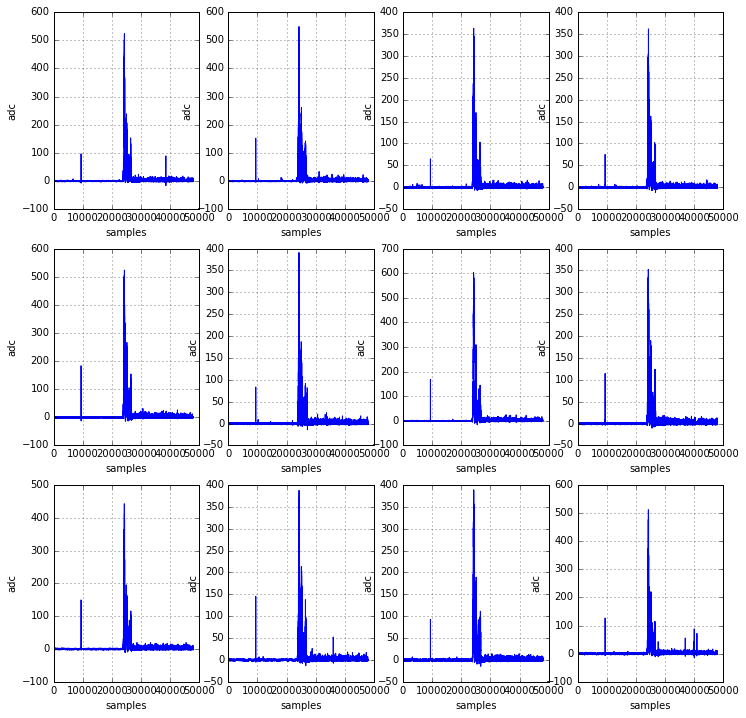

In [10]:
event = 0
t0 = time()
CWF = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr)
t1 = time()        
dt = t1 - t0

print("run over {} events  in {} s".format(event,dt))
mpl.plot_waveforms(CWF)

In [ ]:
t0 = time()
for event in range(pmtrwf.shape[0]):
    CWF = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr)
t1 = time()        
dt = t1 - t0

print("run over {} events  in {} s".format(event,dt))
print("time/event {} s".format(dt/event))

### calibrated PMT sum

In [11]:
event = 0
t0 = time()
CWF = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr)
csum = cpf.calibrated_pmt_sum(CWF, adc_to_pes, n_MAU=200, thr_MAU=5) 
t1 = time()        
dt = t1 - t0

print("run over {} events  in {} s".format(event,dt))

run over 0 events  in 0.183438062668 s


In [12]:
tstep = 25
signal_t = np.arange(0., PMTWL * tstep, tstep)

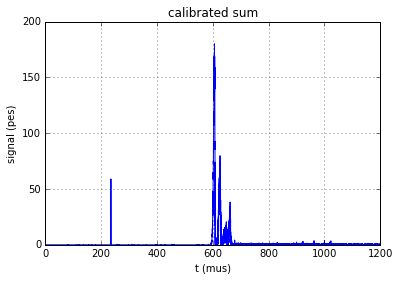

In [13]:
mpl.plot_signal(signal_t/units.mus, csum, title="calibrated sum",
                signal_start=0, signal_end=1200, 
                ymax = 200, 
                t_units='mus', units="pes")

In [ ]:
t0 = time()
for event in range(pmtrwf.shape[0]):
    CWF = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr)
    csum = cpf.calibrated_pmt_sum(CWF, adc_to_pes, n_MAU=200, thr_MAU=5) 
t1 = time()        
dt = t1 - t0

print("run over {} events  in {} s".format(event,dt))
print("time/event {} s".format(dt/event))

###  ZS in PMTs

In [14]:
event = 0
t0 = time()
CWF = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr)
csum = cpf.calibrated_pmt_sum(CWF, adc_to_pes, n_MAU=200, thr_MAU=5) 
wfzs_ene, wfzs_indx = cpf.wfzs(csum, threshold=1*units.pes)
wfzs_t = cpf.time_from_index(wfzs_indx)
t1 = time()        
dt = t1 - t0

print("run over {} events  in {} s".format(event,dt))

run over 0 events  in 0.183401823044 s


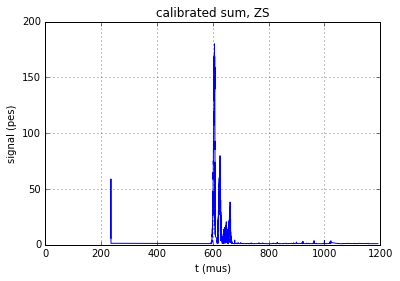

In [15]:
mpl.plot_signal(wfzs_t/units.mus, wfzs_ene, title="calibrated sum, ZS",
                signal_start=0, signal_end=1200, 
                ymax = 200, 
                t_units='mus', units="pes")

In [ ]:
t0 = time()
for event in range(pmtrwf.shape[0]):
    CWF = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr)
    csum = cpf.calibrated_pmt_sum(CWF, adc_to_pes, n_MAU=200, thr_MAU=5)
    wfzs_ene, wfzs_indx = cpf.wfzs(csum, threshold=1*units.pes)
    wfzs_t = cpf.time_from_index(wfzs_indx)
t1 = time()        
dt = t1 - t0

print("run over {} events in {} s".format(event,dt))
print("time/event {} s".format(dt/event))

### Find S12 

In [16]:
event = 0
CWF = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr)
csum = cpf.calibrated_pmt_sum(CWF, adc_to_pes, n_MAU=200, thr_MAU=5) 
wfzs_ene, wfzs_indx = cpf.wfzs(csum, threshold=1*units.pes)
wfzs_t = cpf.time_from_index(wfzs_indx)
S1 = cpf.find_S12(wfzs_ene, wfzs_indx, tmin=0,  tmax=590*units.mus, 
                 lmin=8, lmax=20, stride=4,
                 rebin=False)
S2 = cpf.find_S12(wfzs_ene, wfzs_indx, tmin=590*units.mus,  tmax=1100*units.mus, 
                 lmin=100, lmax=1000000, stride=40,
                 rebin=True, rebin_stride=40)

In [17]:
S1

{0: [array([ 235000.,  235025.,  235050.,  235075.,  235100.,  235125.,
          235150.,  235175.,  235200.,  235225.,  235250.,  235275.,
          235300.,  235325.,  235350.,  235375.]),
  array([  5.93195043,  21.03559257,  40.95658474,  56.01525993,
          58.98818919,  51.01282834,  37.66093463,  25.33503027,
          16.29579392,  11.4940765 ,   8.41424812,   5.57756861,
           3.80647233,   2.63786589,   2.04863497,   1.3435522 ])]}

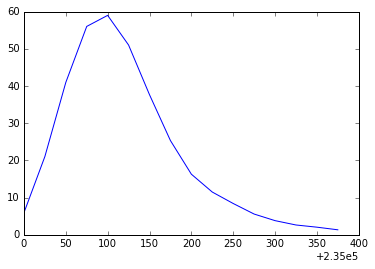

In [18]:
plt.plot(S1[0][0],S1[0][1])

In [ ]:
pf.scan_S12(S1)

In [ ]:
pf.scan_S12(S2)

In [ ]:
t0 = time()
for event in range(pmtrwf.shape[0]):
    
    CWF = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr)
    csum = cpf.calibrated_pmt_sum(CWF, adc_to_pes, n_MAU=200, thr_MAU=5) 
    wfzs_ene, wfzs_indx = cpf.wfzs(csum, threshold=1*units.pes)
    wfzs_t = cpf.time_from_index(wfzs_indx)
    S1 = cpf.find_S12(wfzs_ene, wfzs_indx, tmin=0,  tmax=590*units.mus, 
                 lmin=8, lmax=20, stride=4,
                 rebin=False)
    S2 = cpf.find_S12(wfzs_ene, wfzs_indx, tmin=590*units.mus,  tmax=1100*units.mus, 
                 lmin=100, lmax=1000000, stride=40,
                 rebin=True, rebin_stride=40)

t1 = time()        
dt = t1 - t0

print("run over {} events in {} s".format(event,dt))
print("time/event {} s".format(dt/event))

### SiPMs

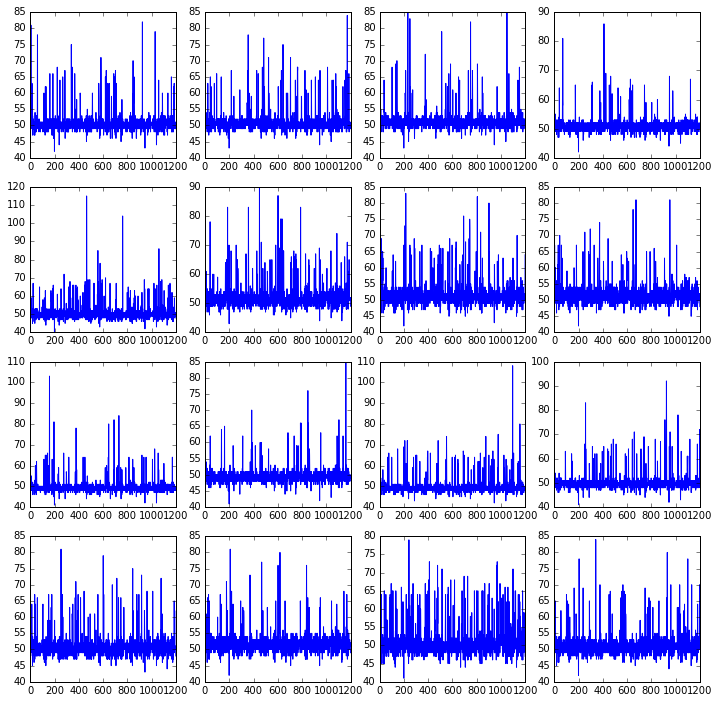

In [19]:
event=0
mpl.plot_sipm(sipmrwf[event], nmin=0, nmax=16, x=4, y=4)

### Subtract baseline, and set a cut to supress dark current

In [20]:
event=0
sipm = cpf.signal_sipm(sipmrwf[event], adc_to_pes_sipm, thr=5*units.pes, n_MAU=100)

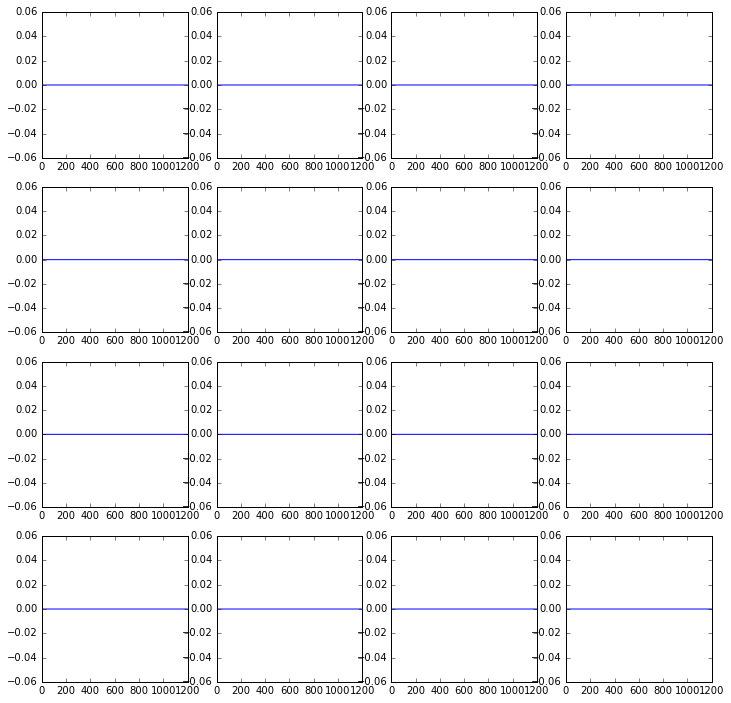

In [21]:
mpl.plot_sipm(sipm, nmin=0, nmax=16, x=4, y=4)

In [22]:
event=0
t0 = time()
sipm = cpf.signal_sipm(sipmrwf[event], adc_to_pes_sipm, thr=10*units.pes, n_MAU=100)
SIPM = cpf.select_sipm(sipm)
t1 = time()        
dt = t1 - t0

print("run in {} s".format(dt))
print('number of SiPM with signal = {}'.format(len(SIPM)))

run in 0.191027164459 s
number of SiPM with signal = 22


In [23]:
SIPM

{0: [224, array([ 0.,  0.,  0., ...,  0.,  0.,  0.])],
 1: [229, array([ 0.,  0.,  0., ...,  0.,  0.,  0.])],
 2: [240, array([ 0.,  0.,  0., ...,  0.,  0.,  0.])],
 3: [241, array([ 0.,  0.,  0., ...,  0.,  0.,  0.])],
 4: [242, array([ 0.,  0.,  0., ...,  0.,  0.,  0.])],
 5: [243, array([ 0.,  0.,  0., ...,  0.,  0.,  0.])],
 6: [244, array([ 0.,  0.,  0., ...,  0.,  0.,  0.])],
 7: [245, array([ 0.,  0.,  0., ...,  0.,  0.,  0.])],
 8: [246, array([ 0.,  0.,  0., ...,  0.,  0.,  0.])],
 9: [247, array([ 0.,  0.,  0., ...,  0.,  0.,  0.])],
 10: [249, array([ 0.,  0.,  0., ...,  0.,  0.,  0.])],
 11: [252, array([ 0.,  0.,  0., ...,  0.,  0.,  0.])],
 12: [253, array([ 0.,  0.,  0., ...,  0.,  0.,  0.])],
 13: [255, array([ 0.,  0.,  0., ...,  0.,  0.,  0.])],
 14: [290, array([ 0.,  0.,  0., ...,  0.,  0.,  0.])],
 15: [291, array([ 0.,  0.,  0., ...,  0.,  0.,  0.])],
 16: [294, array([ 0.,  0.,  0., ...,  0.,  0.,  0.])],
 17: [298, array([ 0.,  0.,  0., ...,  0.,  0.,  0.])],
 1

### PMAPS

#### Structure of a PMAP
1. S1 and S2 are dictionaries: each dictionary index is one S1/S2 candidate. Each dictionary value is a list which contains two elements. Element [0] is a np vector of times, element[1] is a np vector of energies in pes.
2. S2Si is a dictionary. Each index correspond to the S2 index. Each value is a list, whose length is equal to the number of SiPM with no zero signal in the S2 window. The list has as a first element the SiPM index and as a second the energy of each SiPM in the S2 window. Time is not neeeded (comes with S2).

#### S2 window
1. Given an S2 (T,E), obtain the relevant index range. 
2. Given a vector with SIPMs (energies above threshold), returns
    a list of np arrays. Each element of the list is the S2 window 
    in the SiPM (if not zero)
3. Given a vector with SIPMs (energies above threshold), and a 
    dictionary of S2s, S2d, returns a dictionary of SiPMs-S2.
    Each index of the dictionary correspond to one S2 and is
    a list of np arrays. Each element of the list is the S2 window 
    in the SiPM (if not zero)

In [24]:
event = 0
t0 = time()
CWF = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr)
csum = cpf.calibrated_pmt_sum(CWF, adc_to_pes, n_MAU=200, thr_MAU=5) 
wfzs_ene, wfzs_indx = cpf.wfzs(csum, threshold=1*units.pes)
wfzs_t = cpf.time_from_index(wfzs_indx)
S1 = cpf.find_S12(wfzs_ene, wfzs_indx, tmin=0,  tmax=590*units.mus, 
                 lmin=8, lmax=20, stride=4,
                 rebin=False)
S2 = cpf.find_S12(wfzs_ene, wfzs_indx, tmin=590*units.mus,  tmax=1100*units.mus, 
                 lmin=100, lmax=1000000, stride=40,
                 rebin=True, rebin_stride=40)

t1 = time()        
dt = t1 - t0

print("run in {} s".format(dt))

run in 0.197341918945 s


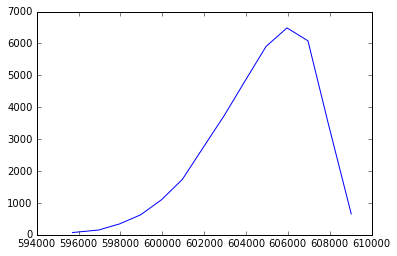

In [25]:
plt.plot(S2[0][0],S2[0][1])

In [26]:
S2[0]

[array([ 595713.75     ,  596962.5      ,  597962.5      ,  598962.5      ,
         599962.5      ,  600962.5      ,  601962.5      ,  602962.5      ,
         603962.5      ,  604962.5      ,  605962.5      ,  606962.5      ,
         607962.5      ,  609031.4516129]),
 array([   71.61901004,   149.69644997,   342.85044108,   625.061768  ,
         1098.1140198 ,  1738.70029371,  2741.89185973,  3741.33329112,
         4831.69608471,  5908.48124323,  6488.17983451,  6084.5070511 ,
         3413.97303015,   655.66406931])]

In [27]:
sipml = pf.sipm_S2(SIPM,S2[0], thr=5*units.pes)

In [28]:
sipml

[[240, array([  0.        ,   0.        ,   0.        ,   0.        ,
          10.02466184,  26.30793917,  24.36945378,  32.83417334,
          40.84657965,  34.83727492,  40.71734729,  40.26503403,
          30.31414233,  21.0740286 ])],
 [241, array([  0.        ,   0.        ,   0.        ,   0.        ,
           0.        ,  12.2968544 ,  15.37715159,  18.02620717,
          26.28140363,  20.30562709,  23.81716588,  15.62357536,
          14.2682446 ,   0.        ])],
 [242, array([  0.        ,   0.        ,   0.        ,   0.        ,
           0.        ,   0.        ,   0.        ,   0.        ,
           0.        ,  10.13134752,   0.        ,   0.        ,
           0.        ,   0.        ])],
 [244, array([  0.        ,   0.        ,   0.        ,   0.        ,
           0.        ,   0.        ,   0.        ,  21.49589252,
          14.6973008 ,  13.05835458,  22.70992675,  13.96888026,
           0.        ,  15.91133503])],
 [245, array([  0.        ,   0.        

In [29]:
sipmd = pf.sipm_S2_dict(SIPM, S2, thr=5*units.pes)

In [30]:
sipmd

{0: [[240, array([  0.        ,   0.        ,   0.        ,   0.        ,
           10.02466184,  26.30793917,  24.36945378,  32.83417334,
           40.84657965,  34.83727492,  40.71734729,  40.26503403,
           30.31414233,  21.0740286 ])],
  [241, array([  0.        ,   0.        ,   0.        ,   0.        ,
            0.        ,  12.2968544 ,  15.37715159,  18.02620717,
           26.28140363,  20.30562709,  23.81716588,  15.62357536,
           14.2682446 ,   0.        ])],
  [242, array([  0.        ,   0.        ,   0.        ,   0.        ,
            0.        ,   0.        ,   0.        ,   0.        ,
            0.        ,  10.13134752,   0.        ,   0.        ,
            0.        ,   0.        ])],
  [244, array([  0.        ,   0.        ,   0.        ,   0.        ,
            0.        ,   0.        ,   0.        ,  21.49589252,
           14.6973008 ,  13.05835458,  22.70992675,  13.96888026,
            0.        ,  15.91133503])],
  [245, array([  0.  

In [32]:
event = 0
t0 = time()
sipmd = pf.sipm_S2_dict(SIPM, S2, thr=5*units.pes)
t1 = time()        
dt = t1 - t0

print("run in {} s".format(dt))

run in 0.000457048416138 s


### The full pre-proc 

In [34]:
event = 0
t0 = time()
CWF = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr)
csum = cpf.calibrated_pmt_sum(CWF, adc_to_pes, n_MAU=200, thr_MAU=5) 
wfzs_ene, wfzs_indx = cpf.wfzs(csum, threshold=1*units.pes)
wfzs_t = cpf.time_from_index(wfzs_indx)
S1 = cpf.find_S12(wfzs_ene, wfzs_indx, tmin=0,  tmax=590*units.mus, 
                 lmin=8, lmax=20, stride=4,
                 rebin=False)
S2 = cpf.find_S12(wfzs_ene, wfzs_indx, tmin=590*units.mus,  tmax=1100*units.mus, 
                 lmin=100, lmax=1000000, stride=40,
                 rebin=True, rebin_stride=40)
sipm = cpf.signal_sipm(sipmrwf[event], adc_to_pes_sipm, thr=10*units.pes, n_MAU=100)
SIPM = cpf.select_sipm(sipm)
sipmd = pf.sipm_S2_dict(SIPM, S2, thr=5*units.pes)
t1 = time()        
dt = t1 - t0

print("run in {} s".format(dt))

run in 0.37536406517 s


#### Plot SiPMs

In [35]:
len(DataSiPM)

1792

In [36]:
sipml =sipmd[0]

In [37]:
sipml[0]

[240, array([  0.        ,   0.        ,   0.        ,   0.        ,
         10.02466184,  26.30793917,  24.36945378,  32.83417334,
         40.84657965,  34.83727492,  40.71734729,  40.26503403,
         30.31414233,  21.0740286 ])]

In [38]:
sipml[1]

[241, array([  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,  12.2968544 ,  15.37715159,  18.02620717,
         26.28140363,  20.30562709,  23.81716588,  15.62357536,
         14.2682446 ,   0.        ])]

In [39]:
def plot_ene_sipm(sipmd, Xs, Ys, radius=3):
    """
    plots the reconstructed energy of the SiPMs
    input: sipm dictionary
    """

    r = np.ones(len(Xs)) * radius
    col = np.zeros(len(Xs))
    for i in sipmd.keys():
        sipml = sipmd[i]
        for sipm in sipml:
            sipm_n = sipm[0]
            sipm_wf = sipm[1]
            sipm_e = np.sum(sipm_wf)
            col[sipm_n] = sipm_e

    plt.figure(figsize=(10, 10))
    plt.subplot(aspect="equal")
    mpl.circles(Xs, Ys, r, c=col, alpha=0.5, ec="none")
    plt.colorbar()

    plt.xlim(-198, 198)
    plt.ylim(-198, 198)
    
    return col

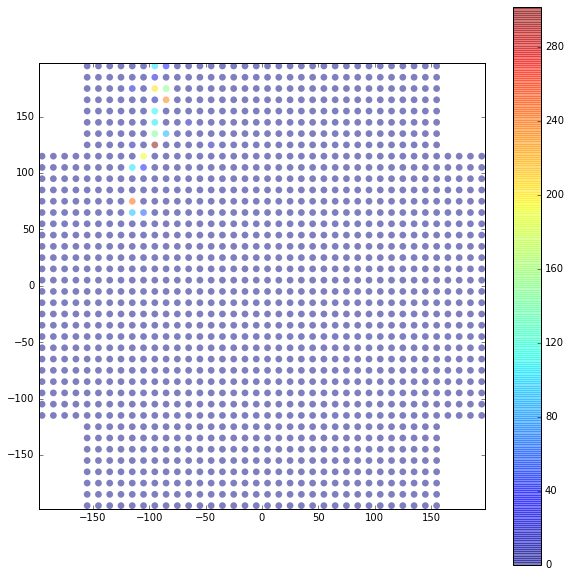

In [40]:
col = plot_ene_sipm(sipmd,xs,ys)

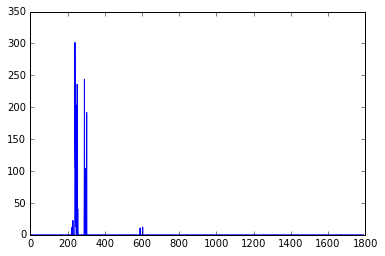

In [41]:
plt.plot(col)

In [ ]:
S2